**Analysis owner**: Felipe Matheus <br>
**Date**: 12/10/2021 <br>
**Related Links**:

The objective of this notebook is to asses data from Jeff and create a DataFrame modeling the problem.

# Index
1. Setup
2. Loading data
3. Plotting data
4. Feature Engineering - Creating DataFrame

# 1. Setup

Libs

In [1]:
import os
import sys
import json
import itertools
import pickle
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#import warnings

%load_ext autoreload
%autoreload 2

Modules

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.DataLoader import DataLoader
from src.processing.Processing import Processing
from src.visualization.Plots import Plots
from src.feature_engineering.FeatureEngineering import FeatureEngineering
from src.utils import read_files

Variables

In [3]:
pd.options.display.max_rows = 6
with open('../config/variables.json') as json_file:
    var = json.load(json_file)
RAW_DATA = var.get('RAW_DATA')
TRAIN_FOLDER = var.get('TRAIN_FOLDER')
TEST_FOLDER = var.get('TEST_FOLDER')

Objects

In [4]:
load = DataLoader(RAW_DATA)
processing = Processing()
plots = Plots()
feng = FeatureEngineering()

# 2. Loading data

In [5]:
fits = load.load_fits(read_files(RAW_DATA))
energies = processing.get_energy_dict(fits)

In [6]:
energies

{'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
        120.36540315,  19.78994792]),
 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
        168.7988886 , 123.45042534]),
 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
        22.68337052, 29.00606452]),
 'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
         68.28175692, 165.50336178]),
 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
         8.4234955 , 36.1971228 ]),
 'ba': array([79.2461234 , 32.05256775, 82.40269725, ..., 23.9200605 ,
        34.94371734, 10.8930531 ]),
 'co': array([ 16.5188232 ,  25.5491515 ,  56.8609797 , ..., 119.90803846,
        118.33637915, 121.63595295])}

In [7]:
len(tuple(map(dict, itertools.combinations(energies.items(), 2))))

21

In [8]:
energies_tuple = processing.get_energy_tuple(fits)
energies_tuple
len(tuple(map(tuple, itertools.combinations(energies_tuple, 2))))

21

21 possible combinations

Assessing if they have the same lenght

In [10]:
for key in energies.keys():
    print(len(energies[key]))

12487896
135563
14217618
658548
9220770
15852843
3394654


The lowest possible sum will be: <br>
658548 <br>
135563 + <br>
<br>
794111

# 3. Plotting Data

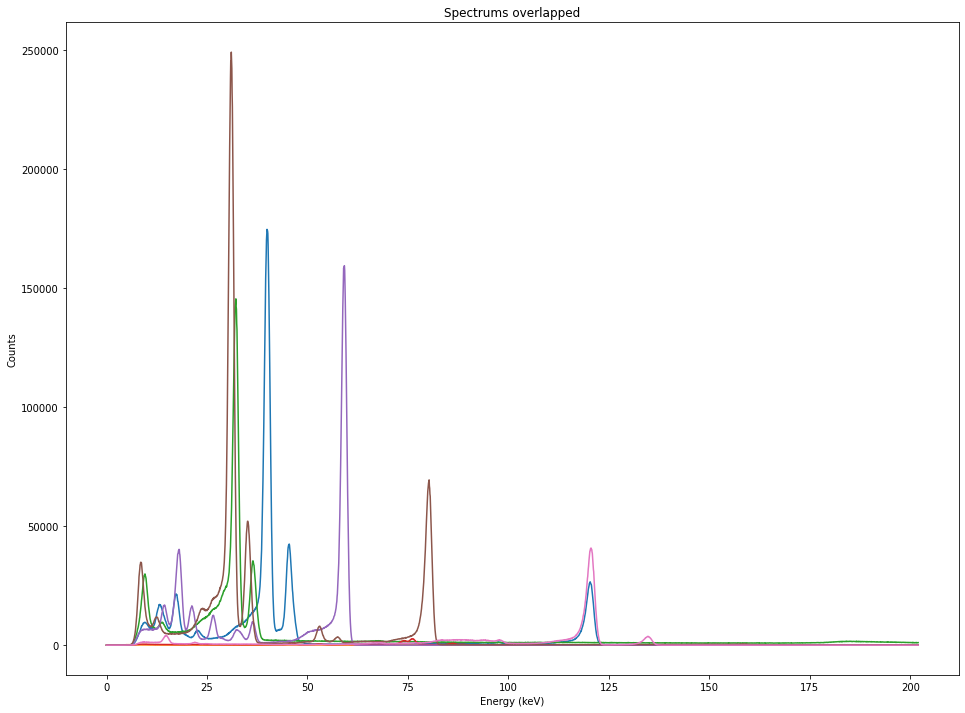

In [11]:
plots.plot_spectrums_overlapping(energies, "Spectrums overlapped")

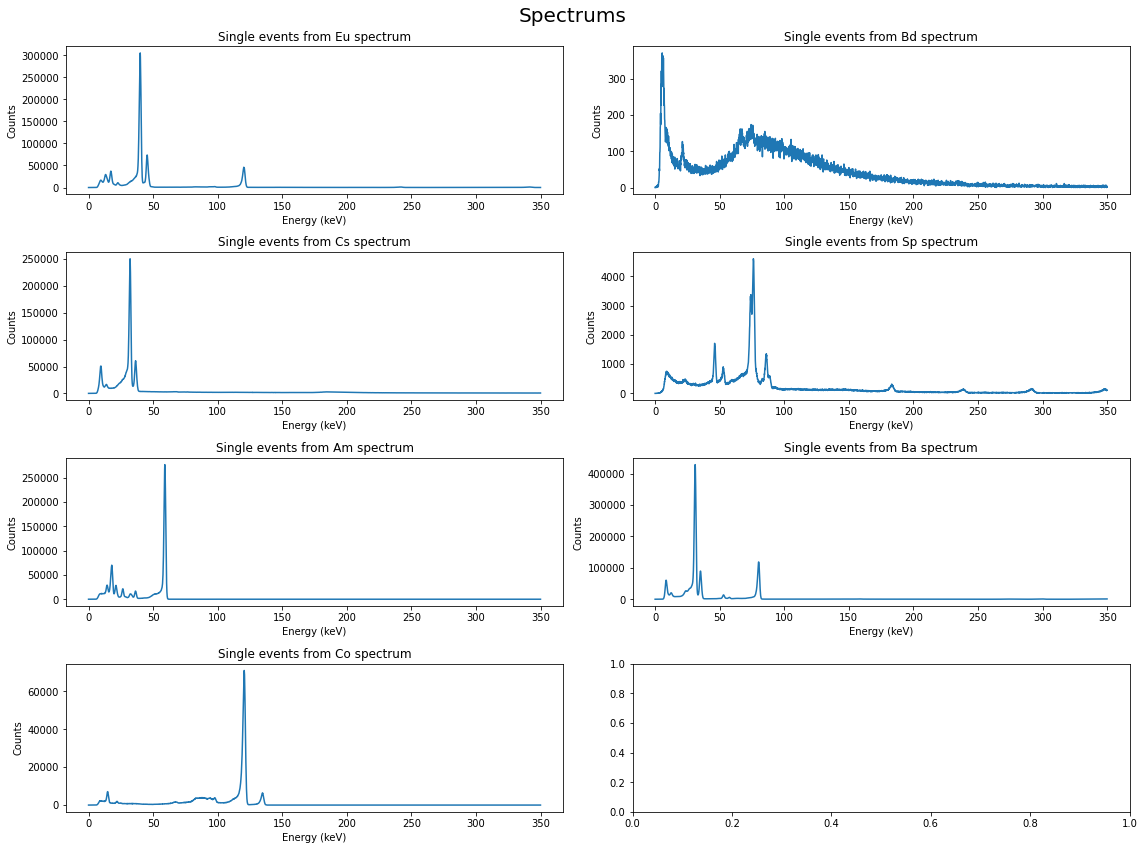

In [12]:
plots.plot_spectrums(energies, "Spectrums")

# 4. Feature Engineering - Creating DataFrame

Idea is to have around half million data to train (each model or all of them?)

## Variables and Hyperparameters

- Each mixed sample will have size of $794111/reduction factor$ , because it is the lowest possible lenght (which would be Bd source with Sp source).
- We need to add a reduction factor because if it would be 1, the model would always guess right the combination Bd with Co.
- The bigger the reduction factor, harder will be for the model. So we expect our accuracy will be inversely proportional to this reduction factor.
- Another hyperparameter set: number of bins. By only looking the graphics, we will choose 300 bins, from 0 to 300 considering each one, but considering each half should also be a possibility.

---

Edit 20/10/2021:

- We decided to choose HALF_OUTPUT_SIZE as half of the lowest source data, which is 135563/2

#### Important Observation: What happen if 2 photons from 2 different sources hit the same pixel at the same time? Does it count as a sum?

## Declaring Hyperparameters

In [17]:
REDUCTION_FACTOR = 4

## Declaring Variables

In [20]:
MINIMUM_COMBINATION_LENGHT = len(energies["bd"]) + len(energies["sp"])
OUTPUT_SIZE = MINIMUM_COMBINATION_LENGHT//REDUCTION_FACTOR
HALF_OUTPUT_SIZE = OUTPUT_SIZE//2

## 4.1 Mixing Numpy arrays of 2 different energies source
Measuring time of the biggest case

In [29]:
HALF_OUTPUT_SIZE = 135563//2

In [30]:
%%time
elem1 = "ba"
elem2 = "cs"
combination = feng.mix_numpy_arrays_comp_list(
    tuple_arrays=(energies[elem1], energies[elem2]),
    tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
)

CPU times: user 2.45 ms, sys: 0 ns, total: 2.45 ms
Wall time: 2.15 ms


In [31]:
len(combination)

135562

### Visualizing combination

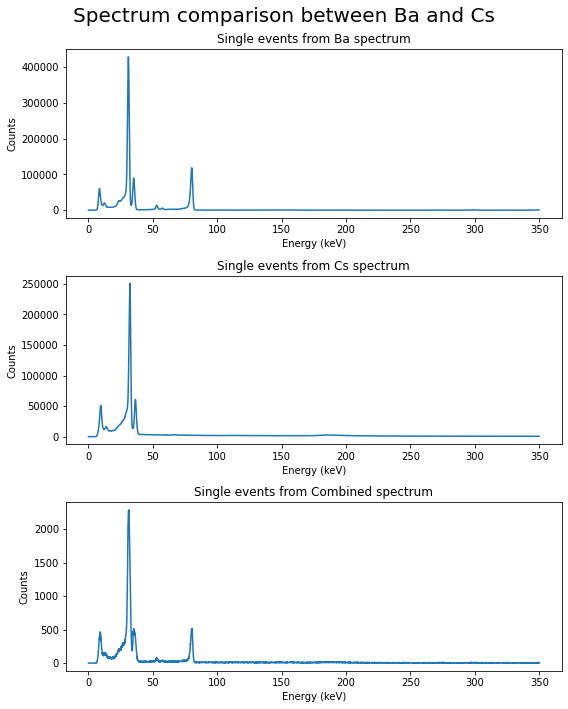

In [32]:
plots.plot_spectrums(
    energies_dict={elem1:energies[elem1], elem2:energies[elem2], "Combined": combination},
    title="Spectrum comparison between Ba and Cs",
    figsize=(8,10),
    ncols=1
)

## 4.2 Counting Bins

In [33]:
%%time
elem1 = "ba"
elem2 = "cs"
_ = feng.count_bins(
    feng.mix_numpy_arrays_comp_list(
        tuple_arrays=(energies[elem1], energies[elem2]),
        tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
    )
)

CPU times: user 6.06 ms, sys: 1.3 ms, total: 7.36 ms
Wall time: 7.01 ms


In [34]:
%%time
elem1 = "ba"
elem2 = "cs"
percentages = feng.count_bins_percentage(
    feng.mix_numpy_arrays_comp_list(
        tuple_arrays=(energies[elem1], energies[elem2]),
        tuple_amounts=(HALF_OUTPUT_SIZE, HALF_OUTPUT_SIZE)
    ).round().astype(str)
)

CPU times: user 62.2 ms, sys: 9.47 ms, total: 71.7 ms
Wall time: 71.1 ms


considering the time of 753 ms per iteration, if we want to make a DataFrame of N rows, we need to iterate N/21 times. 

Once 21 is the number of combinations 7 choose 2.

## 4.3 Iterating

Example

In [35]:
%%time
combination_dict_example = feng.gen_mixed_energies_dict(
    energies_dict=energies,
    photons_amount=HALF_OUTPUT_SIZE,
    amount_per_combination=1
)

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
       168.7988886 , 123.45042534])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
       22.68337052, 29.00606452])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
        8.4234955 , 36.197122

In [36]:
combination_dict_example

{'eu_bd_0': {'-2.0': 1.4753396969652263e-05,
  '1.0': 4.426019090895679e-05,
  '10.0': 0.009766748793909798,
  '100.0': 0.003474424986353108,
  '101.0': 0.003216240539384193,
  '102.0': 0.0033859046045351944,
  '103.0': 0.0032236172378690194,
  '104.0': 0.003688349242413066,
  '105.0': 0.0034154113984744988,
  '106.0': 0.0034522948908986295,
  '1060.0': 7.376698484826132e-06,
  '107.0': 0.003607205559079978,
  '108.0': 0.0033047609212021067,
  '109.0': 0.0033416444136262374,
  '11.0': 0.007686519821188829,
  '110.0': 0.0037916230212006316,
  '111.0': 0.003319514318171759,
  '1114.0': 8.852038181791358e-05,
  '112.0': 0.003474424986353108,
  '1127.0': 1.4753396969652263e-05,
  '113.0': 0.003444918192413803,
  '114.0': 0.003651465749988935,
  '115.0': 0.0036293356545344566,
  '116.0': 0.0038580133075640666,
  '117.0': 0.004337498709077765,
  '118.0': 0.005930865581800209,
  '119.0': 0.010002803145424235,
  '12.0': 0.009183989613608534,
  '120.0': 0.016118086189345095,
  '121.0': 0.013772

Approximately 15 seconds per 1 iteration (for 21 possibilities)

Real DataFrame creation

5 horas

In [ ]:
1 minuto 4 iteracoes
1 hora 240 iteracoes
5 horas 1200 iteracoes

In [37]:
%%time
combination_dict = feng.gen_mixed_energies_dict(
    energies_dict=energies,
    photons_amount=HALF_OUTPUT_SIZE,
    amount_per_combination=1200
)

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
       168.7988886 , 123.45042534])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'cs': array([31.3336658 ,  9.0872523 , 12.90240315, ...,  9.4992777 ,
       22.68337052, 29.00606452])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'sp': array([ 72.42276372,  76.79458866, 152.93108048, ...,  59.78663842,
        68.28175692, 165.50336178])} 

Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'am': array([58.56808924, 59.71696083, 17.71015428, ..., 51.02839084,
        8.4234955 , 36.197122

## 4.2.3 Parallelizing

In [46]:
%%time
combination_dict = feng.gen_mixed_energies_dict_p(
    energies_dict=energies,
    photons_amount=HALF_OUTPUT_SIZE,
    amount_per_combination=1200
)


Starting iteration through: 
 {'eu': array([ 26.36664126,  39.78757692,  45.61476704, ...,  38.97671296,
       120.36540315,  19.78994792]), 'bd': array([ 70.5295808 , 339.49916514,  51.57864558, ...,  29.3239512 ,
       168.7988886 , 123.45042534])} 



Process ForkPoolWorker-63:
Process ForkPoolWorker-67:
Process ForkPoolWorker-61:
Process ForkPoolWorker-66:
Process ForkPoolWorker-65:
Process ForkPoolWorker-71:
Process ForkPoolWorker-64:
Process ForkPoolWorker-68:
Process ForkPoolWorker-62:
Process ForkPoolWorker-72:
Traceback (most recent call last):
Process ForkPoolWorker-70:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-69:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessin

KeyboardInterrupt: 

## 4.4 Transforming into DataFrame

Example:

In [ ]:
# pd.DataFrame.from_dict(
#     {
#     "sm":percentages,
#     "sn":percentages
#     }, orient='index'
# )

,10.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,...,905.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0
sm,0.018528,0.000679,0.000633,0.000625,0.000687,0.000688,0.000704,0.000709,0.000722,0.000672,...,0.000001,0.000684,0.000699,0.000691,0.000687,0.000722,0.000672,0.000652,0.000624,0.000657
sn,0.018528,0.000679,0.000633,0.000625,0.000687,0.000688,0.000704,0.000709,0.000722,0.000672,...,0.000001,0.000684,0.000699,0.000691,0.000687,0.000722,0.000672,0.000652,0.000624,0.000657


In [149]:
# pd.DataFrame.from_dict(combination_dict, orient='index')

,-0.0,-1.0,-2.0,0.0,1.0,10.0,100.0,101.0,102.0,103.0,...,99.0,937.0,1060.0,1114.0,1127.0,1172.0,967.0,990.0,945.0,992.0
sp_ba_0,0.000002,0.000005,0.000002,0.000003,0.000018,0.009827,0.001048,0.001028,0.000973,0.000969,...,0.000920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_cs_0,0.000003,0.000003,NaN,0.000007,0.000010,0.017056,0.001495,0.001492,0.001501,0.001516,...,0.001389,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_bd_0,0.000007,0.000019,0.000008,0.000015,0.000073,0.008614,0.004196,0.004112,0.004329,0.004062,...,0.004327,NaN,0.000002,0.000091,0.000005,0.000005,0.000005,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ba_eu_0,NaN,NaN,NaN,NaN,NaN,0.010795,0.000356,0.000348,0.000338,0.000340,...,0.000474,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN
ba_am_0,NaN,NaN,NaN,NaN,NaN,0.011016,0.000095,0.000103,0.000110,0.000093,...,0.000086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cs_eu_0,NaN,NaN,NaN,NaN,NaN,0.018325,0.000823,0.000853,0.000832,0.000836,...,0.000976,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN


Real

In [38]:
pd.DataFrame.from_dict(combination_dict, orient='index').to_pickle(
    "../data/structured/dataframe_21_1200.pkl"
)

In [40]:
pd.read_pickle("../data/structured/dataframe_21_1200.pkl")

,-1.0,-2.0,1.0,10.0,100.0,101.0,102.0,103.0,104.0,105.0,...,871.0,889.0,899.0,990.0,875.0,944.0,945.0,967.0,-0.0,992.0
eu_bd_0,0.000015,0.000015,0.000030,0.009258,0.003755,0.003283,0.003688,0.003548,0.003445,0.003445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eu_bd_1,0.000022,0.000015,0.000044,0.009922,0.003445,0.003703,0.003305,0.003681,0.003578,0.003467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eu_bd_2,0.000030,0.000007,0.000059,0.009604,0.003548,0.003482,0.003489,0.003290,0.003460,0.003585,...,0.000007,0.00003,0.000007,0.000007,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ba_co_1197,NaN,NaN,NaN,0.008867,0.001977,0.001837,0.001571,0.001778,0.001734,0.001497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ba_co_1198,NaN,NaN,NaN,0.008579,0.001992,0.001586,0.001483,0.001770,0.001468,0.001608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ba_co_1199,NaN,NaN,NaN,0.008439,0.001815,0.001556,0.001711,0.001497,0.001520,0.001549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Todo Transformar aquela base de dados lá inicial em um DF

In [ ]:
df_sr

In [ ]:
# todos os arquivos são os dados reais, mas são pas prises pendant
# la meme condition
#Am -> Amerique
# TP8 -> configuration electronique de 1 a 15
# g0 -> outro parâmetro
# BdF -> bruit de fundo. 
# A gente seleciona
#reveil -> alarm


In [ ]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,1000),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


In [ ]:
name = data_folder + "Am_proche_TP8_calibrated.fits"
    
hdulist = fits.open(name)

hdr = hdulist[1].header
tabdata = hdulist[1].data
    
hdulist.close()

event_num = tabdata.field("FRAME") #Numéro de l'événement
mult = tabdata.field("MULTIPLICITY") #Multiplicité (nombre de pixels touchés par l'événement)
mult_i = tabdata.field("MULT") #Numéro dans la multiplicité
time = tabdata.field("TIME") #Date de l'événement
pixel = tabdata.field("PIXEL") #Numéro du pixel touché
x = tabdata.field("X") #Coordonnée X du pixel touché
y = tabdata.field("Y") #Coordonnée Y du pixel touché
energy = tabdata.field("ENERGY") #Energie mesurée
event_type = tabdata.field("TYPE") #Ne pas s'occuper de celui-là, la colonne existe mais ne renvoie rien de pertinent

single = (mult == 1)

single_energy = energy[single]

spectre, bins = np.histogram(single_energy,range = (0,100),bins = 2000)

plt.plot(bins[:-1],spectre)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Spectre single events")


In [ ]:
on reste avec la multiplicite 1, e melanja com o americium e barium
mistrurar os bagulhos e dai dizer quais que tem
pega esse espectro bonitao, melanja com o dos radioativos 

faz uma coisa parecida com o hotel unico, mistura os espectros com uma porcentagem aleatoria
identifica quais espectros eu to misturando, labeliza eles e depois bota pra treinar. Socalhe AutoMLl

In [ ]:
        # for file in files:
        #     hdulist = fits.open(self.folder+file)
        #     ans[f"{file.lower()}_header"]= hdulist[1].header
        #     ans[f"{file.lower()}_tabdata"]= hdulist[1].data
        #     hdulist.close()

        # return ans
